In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, RocCurveDisplay

renames = {
         'Umean06': "Umean06",
         'Umean01': "Umean01",
         # 'Umean800_600': "Umean800-600",    
         'U10': "U10",
         'wg10_2': "WindGust10",
         's06': "S06",
         'ebwd': "EBWD",
         'Umeanwindinf': "Umeanwindinf",
         'srhe_left': "SRHE",
         'srh06_left': "SRH06",
         'dmi': "DMI",
         'lr_subcloud': "LR-subcloud",
         'lr_freezing': "LR-freezing",
         'lr03': "LR03",
         'lr13': "LR13",
         'wmsi_ml': "WMSI",
         'bdsd': "BDSD",
         'bdsd_cv': "BDSD (CV)",
         'hmi': "HMI",
         'convgust_wet': "ConvGust\n(wet)",
         'convgust_dry': "ConvGust\n(dry)",
         'gustex': "GUSTEX",
         'dmgwind': "DmgWind",
         'dmgwind_fixed': "DmgWind\n(fixed)",
         'dcape': "DCAPE",
         'wmpi': "WMPI",
         'windex': "WINDEX",
         'ddraft_temp': "DowndraftTemp",
         'te_diff': "ThetaeDiff",
         'tei': "TEI",
         'wndg': "WNDG",
         'dcp': "DCP",
         'scp': "SCP",
         'scp_fixed': "SCP (fixed)",
         'sherb': "SHERB",
         'eff_sherb': "SHERBE",
         'sweat': "SWEAT",
         'mucape*s06': "MUCS6",
         'mlcape*s06': "MLCS6",
         'sbcape*s06': "SBCS6",    
         'effcape*s06': "EffCS6",
         't_totals': "T-Totals",
         'k_index': "K-Index",
         'eff_cape': "Eff-CAPE",
         'eff_lcl': "Eff-LCL",
         'ml_cape': "MLCAPE",
         'ml_lcl': "ML-LCL",
         'mu_cape': "MUCAPE",
         'mu_lcl': "MU-LCL",
         'qmean01': "Qmean01",
         'qmean06': "Qmean06",
         'rhminsubcloud':"RHMinSubcloud"}

ind_list = [\
            #Wind indices
            "Umean06","Umean01","U10","wg10_2","s06","ebwd","Umeanwindinf","srhe_left","srh06_left",\
            #Downburst indices
            "dmi","lr_subcloud","lr_freezing","lr03","lr13","wmsi_ml","bdsd","convgust_wet","convgust_dry",\
            "gustex","dmgwind","dmgwind_fixed","dcape","wmpi","windex","ddraft_temp","te_diff","tei","wndg",\
            #Storm mode
            "dcp","scp","scp_fixed",\
            #Severe storm indices
            "sherb","eff_sherb","sweat","mucape*s06","mlcape*s06","effcape*s06","t_totals","k_index",\
            #Thermo indices
            "eff_cape","eff_lcl","ml_cape","ml_lcl","mu_cape","mu_lcl","qmean01","qmean06","rhminsubcloud"\
           ]

ind_list2 = [\
            #Wind indices
            "Umean06","Umean01","U10","wg10_2","s06","ebwd","Umeanwindinf","srhe_left","srh06_left",\
            #Downburst indices
            "dmi","lr_subcloud","lr_freezing","lr03","lr13","wmsi_ml","bdsd","convgust_wet","convgust_dry",\
            "gustex","dmgwind","dmgwind_fixed","dcape","wmpi","windex","ddraft_temp","te_diff","tei","wndg",\
            #Storm mode
            "dcp","scp","scp_fixed",\
            #Severe storm indices
            "sherb","eff_sherb","sweat","sbcape*s06","mucape*s06","mlcape*s06","effcape*s06","t_totals","k_index",\
            #Thermo indices
            "eff_cape","eff_lcl","sb_lcl","ml_cape","ml_lcl","mu_cape","mu_lcl","qmean01","qmean06","rhminsubcloud"\
           ]

def remove_suspect_gusts(df):
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]

def load_scws(rid):

    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df1["rid"] = rid
    df1["scw"] = 1

    return df1

def load_nulls(rid):

    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    df2["rid"] = rid
    df2["scw"] = 0

    return df2

def assign_storm_class(data):

    data["aspect_ratio"] = data.major_axis_length / data.minor_axis_length
    #Linear
    data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
    #Non-linear
    data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
    #Cellular
    data.loc[(data.local_max == 1),"class2"] = "Cellular"
    #Cluster of cells
    data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
    #Supercell
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
    #Linear hybrid
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"

    return data

In [2]:
rids = ["68","64","8","72","75","19","73","78","49","4","40","48","2","66","69","70","71"]
df_scw = pd.DataFrame()
df_null = pd.DataFrame()
for rid in rids:
    print(rid)
    df_scw = pd.concat([df_scw,remove_suspect_gusts(load_scws(rid))],axis=0)
    df_null = pd.concat([df_null,load_nulls(rid)],axis=0)

68
64
8
72
75
19
73
78
49
4
40
48
2
66
69
70
71


In [3]:
df_scw = assign_storm_class(df_scw)
df_null = assign_storm_class(df_null)

In [4]:
df_scw["bdsd_cv"] = df_scw["bdsd"]
df_null["bdsd_cv"] = df_null["bdsd"]

In [5]:
len(ind_list2)

50

In [6]:
auc = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_clusterall.csv")
auc_cv = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_clusterall_cv.csv")
auc1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster1.csv")
auc2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster2.csv")
auc3 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster3.csv")
auc = pd.concat([auc,auc_cv.rename(columns={"bdsd":"bdsd_cv"})],axis=1)

auc_full = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_clusterall.csv",index_col=0)
auc_full_cv = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_clusterall_cv.csv",index_col=0)
auc_full1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster1.csv",index_col=0)
auc_full2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster2.csv",index_col=0)
auc_full3 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster3.csv",index_col=0)
auc_full = pd.concat([auc_full,auc_full_cv.rename({"bdsd":"bdsd_cv"})],axis=0)

In [7]:
auc_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_clusterall_in10km.csv")
auc_cv_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_clusterall_cv_in10km.csv")
auc1_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster1_in10km.csv")
auc2_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster2_in10km.csv")
auc3_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cluster3_in10km.csv")
auc_storm = pd.concat([auc_storm,auc_cv_storm[["bdsd"]].rename(columns={"bdsd":"bdsd_cv"})],axis=1)

auc_full_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_clusterall_in10km.csv",index_col=0)
auc_full_cv_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_clusterall_cv_in10km.csv",index_col=0)
auc_full1_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster1_in10km.csv",index_col=0)
auc_full2_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster2_in10km.csv",index_col=0)
auc_full3_storm = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cluster3_in10km.csv",index_col=0)
auc_full_storm = pd.concat([auc_full_storm,auc_full_cv_storm.rename({"bdsd":"bdsd_cv"})],axis=0)

In [8]:
auc_linear = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_linear.csv")
auc_nonlinear = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_nonlinear.csv")
auc_cell = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cell.csv")
auc_cellcluster = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_cellcluster.csv")
auc_supercell = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_supercell.csv")
auc_embeddedsup = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_era5_embeddedsup.csv")

auc_full_linear = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_linear.csv",index_col=0)
auc_full_nonlinear = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_nonlinear.csv",index_col=0)
auc_full_cell = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cell.csv",index_col=0)
auc_full_cellcluster = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_cellcluster.csv",index_col=0)
auc_full_supercell = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_supercell.csv",index_col=0)
auc_full_embeddedsup = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/auc_full_era5_embeddedsup.csv",index_col=0)


In [9]:
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

def plot(df_scw, df_null, data, data_full, ax, color, y1, renames, ylabel, letter, y2=0.8, yticks=None):
    
    if yticks is None:
        yticks=np.arange(y1,y2+0.1,0.1)
        
    sns.violinplot(data=data.loc[:,data_full.sort_values("auc",ascending=False).iloc[0:10].index.values].rename(columns=renames),color=color,inner=None,scale="width")
    sns.scatterplot(data=data_full.sort_values("auc",ascending=False).iloc[0:10],s=100,edgecolor="k",linewidth=2,palette=["white"],legend=False,markers="d")

    plt.gca().tick_params(axis="x",labelrotation=45)
    plt.yticks(yticks)    
    plt.ylim([y1,y2])
    plt.gca().tick_params(labelsize=15)
    plt.ylabel(ylabel,size=22)
    plt.xlabel("")
    plt.gca().grid(axis="y",ls="--")
    ax.text(0.05,0.1,letter+")",transform=ax.transAxes,size=18)
    
    scw_mean=df_scw[data_full.sort_values("auc",ascending=False).iloc[0:10].index.values].mean() 
    null_mean=df_null[data_full.sort_values("auc",ascending=False).iloc[0:10].index.values].mean()
    ax.plot(((scw_mean >= null_mean) * -1) + 0.95,marker="*",ls="none",color="k",ms=10)
    

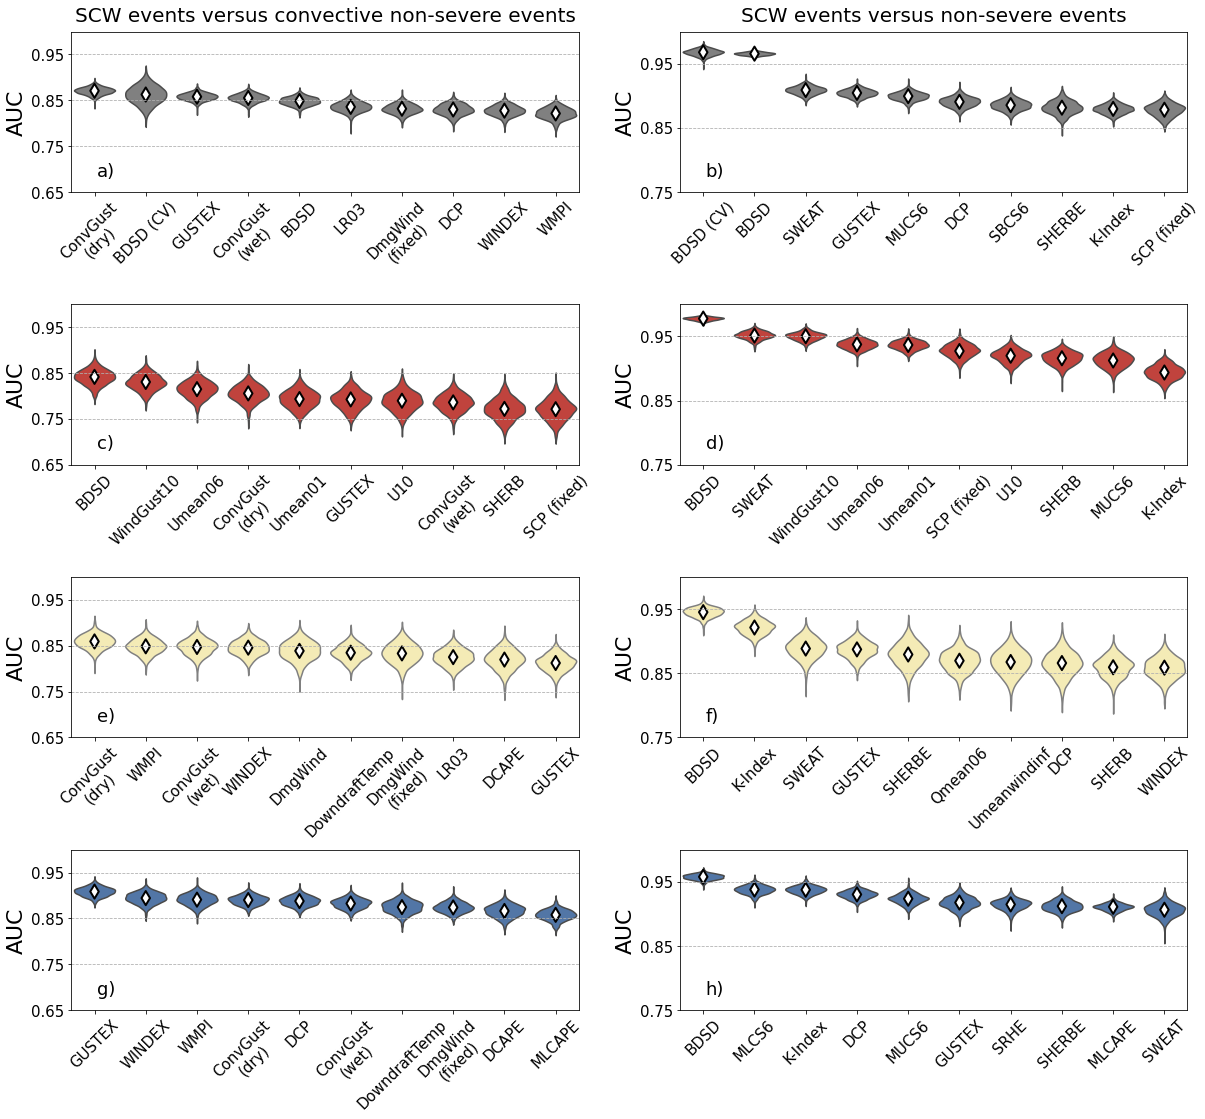

In [15]:
plt.figure(figsize=[20,18])        
plot(df_scw.query("in10km==1"), df_null.query("in10km==1"), auc_storm[ind_list+["bdsd_cv"]], auc_full_storm.loc[ind_list+["bdsd_cv"]], plt.subplot(4,2,1),(0.5,0.5,0.5),0.65,renames,"AUC","a",y2=1)
plt.title("SCW events versus convective non-severe events",size=20,pad=10)
plot(df_scw.query("(in10km==1) & (cluster==1)"), df_null.query("(in10km==1) & (cluster==1)"), auc1_storm[ind_list], auc_full1_storm.loc[ind_list], plt.subplot(4,2,3),p[0],0.65,renames,"AUC","c",y2=1)
plot(df_scw.query("(in10km==1) & (cluster==2)"), df_null.query("(in10km==1) & (cluster==2)"), auc2_storm[ind_list], auc_full2_storm.loc[ind_list], plt.subplot(4,2,5),p[1],0.65,renames,"AUC","e",y2=1)
plot(df_scw.query("(in10km==1) & (cluster==0)"), df_null.query("(in10km==1) & (cluster==0)"), auc3_storm[ind_list], auc_full3_storm.loc[ind_list], plt.subplot(4,2,7),p[2],0.65,renames,"AUC","g",y2=1)

plot(df_scw, df_null, auc, auc_full, plt.subplot(4,2,2),(0.5,0.5,0.5),0.75,renames,"AUC","b",y2=1)
plt.title("SCW events versus non-severe events",size=20,pad=10)
plot(df_scw.query("cluster==1"), df_null.query("cluster==1"), auc1[ind_list], auc_full1.loc[ind_list], plt.subplot(4,2,4),p[0],0.75,renames,"AUC","d",y2=1)
plot(df_scw.query("cluster==2"), df_null.query("cluster==2"), auc2[ind_list], auc_full2.loc[ind_list], plt.subplot(4,2,6),p[1],0.75,renames,"AUC","f",y2=1)
plot(df_scw.query("cluster==0"), df_null.query("cluster==0"), auc3[ind_list], auc_full3.loc[ind_list], plt.subplot(4,2,8),p[2],0.75,renames,"AUC","h",y2=1)

plt.subplots_adjust(hspace=0.7)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/skill.jpeg",bbox_inches="tight",dpi=500)

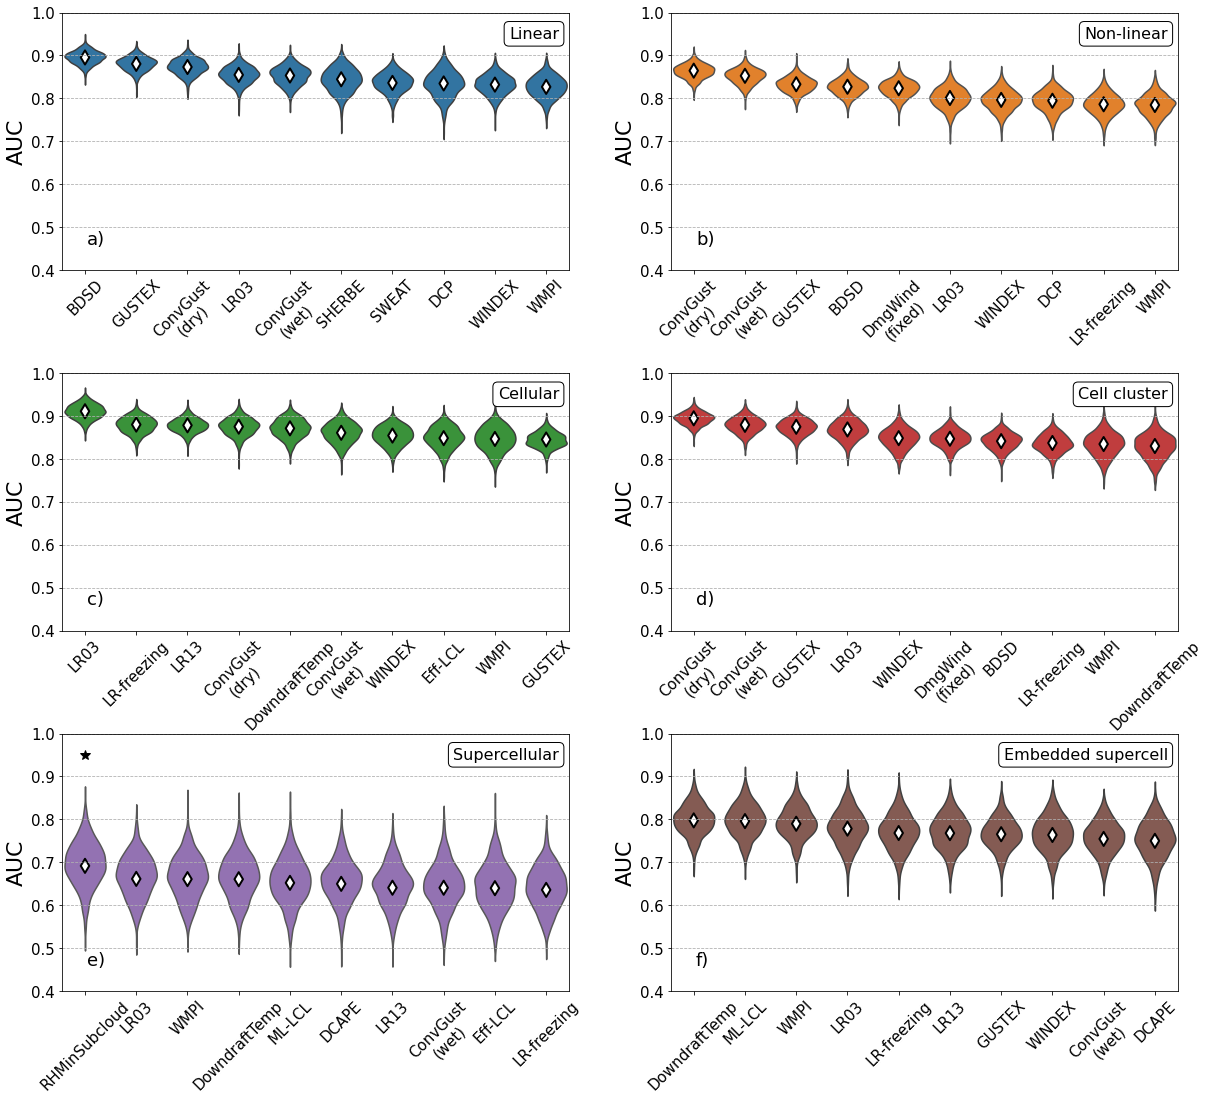

In [11]:
plt.figure(figsize=[20,18])        
plot(df_scw[(df_scw["class2"]=="Linear") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Linear") & (df_null["in10km"]==1)], 
     auc_linear[ind_list], auc_full_linear.loc[ind_list], plt.subplot(3,2,1),"tab:blue",0.4,renames,"AUC","a",y2=1)
plt.gca().text(0.98,0.90,"Linear",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})

plot(df_scw[(df_scw["class2"]=="Non-linear") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Non-linear") & (df_null["in10km"]==1)], 
     auc_nonlinear[ind_list], auc_full_nonlinear.loc[ind_list], plt.subplot(3,2,2),"tab:orange",0.4,renames,"AUC","b",y2=1)
plt.gca().text(0.98,0.90,"Non-linear",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})

plot(df_scw[(df_scw["class2"]=="Cellular") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Cellular") & (df_null["in10km"]==1)], 
     auc_cell[ind_list], auc_full_cell.loc[ind_list], plt.subplot(3,2,3),"tab:green",0.4,renames,"AUC","c",y2=1)
plt.gca().text(0.98,0.90,"Cellular",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})

plot(df_scw[(df_scw["class2"]=="Cell cluster") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Cell cluster") & (df_null["in10km"]==1)], 
     auc_cellcluster[ind_list], auc_full_cellcluster.loc[ind_list], plt.subplot(3,2,4),"tab:red",0.4,renames,"AUC","d",y2=1)
plt.gca().text(0.98,0.90,"Cell cluster",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})

plot(df_scw[(df_scw["class2"]=="Supercellular") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Supercellular") & (df_null["in10km"]==1)], 
     auc_supercell[ind_list], auc_full_supercell.loc[ind_list], plt.subplot(3,2,5),"tab:purple",0.4,renames,"AUC","e",y2=1)
plt.gca().text(0.98,0.90,"Supercellular",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})

plot(df_scw[(df_scw["class2"]=="Embedded supercell") & (df_scw["in10km"]==1)], df_null[(df_null["class2"]=="Embedded supercell") & (df_null["in10km"]==1)], 
     auc_embeddedsup[ind_list], auc_full_embeddedsup.loc[ind_list], plt.subplot(3,2,6),"tab:brown",0.4,renames,"AUC","f",y2=1)
plt.gca().text(0.98,0.90,"Embedded supercell",transform=plt.gca().transAxes,size=16,ha="right",bbox={"boxstyle":'round',"facecolor":"white"})


plt.subplots_adjust(hspace=0.4)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/skill_in10km_storm_class.jpeg",bbox_inches="tight",dpi=500)